1. Carga y exploración de los datos

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix




Carga y exploración de los datos

In [5]:
df = pd.read_csv('Housing.csv')

print("Dimensiones dataset: ", df.shape)
print("\nTipo de datos por columna: \n", df.dtypes)
print("\n Primeras 5 filas: \n", df.head())


Dimensiones dataset:  (545, 13)

Tipo de datos por columna: 
 price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

 Primeras 5 filas: 
       price  area  bedrooms  ...  parking  prefarea furnishingstatus
0  13300000  7420         4  ...        2       yes        furnished
1  12250000  8960         4  ...        3        no        furnished
2  12250000  9960         3  ...        2       yes   semi-furnished
3  12215000  7500         4  ...        3       yes        furnished
4  11410000  7420         4  ...        2        no        furnished

[5 rows x 13 columns]


2. Analisis de valores nulos

In [8]:
print(" Valores nulos por columna:")
print(df.isna().sum())
print("\n Resumen estadístico: \n")
print(df.select_dtypes(include=[np.number]).describe())


 Valores nulos por columna:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

 Resumen estadístico: 

              price          area  ...     stories     parking
count  5.450000e+02    545.000000  ...  545.000000  545.000000
mean   4.766729e+06   5150.541284  ...    1.805505    0.693578
std    1.870440e+06   2170.141023  ...    0.867492    0.861586
min    1.750000e+06   1650.000000  ...    1.000000    0.000000
25%    3.430000e+06   3600.000000  ...    1.000000    0.000000
50%    4.340000e+06   4600.000000  ...    2.000000    0.000000
75%    5.740000e+06   6360.000000  ...    2.000000    1.000000
max    1.330000e+07  16200.000000  ...    4.000000    3.000000

[8 rows x 6 columns]


No hay valores nulos, no faltan columnas clave

Histogramas y boxplot de price

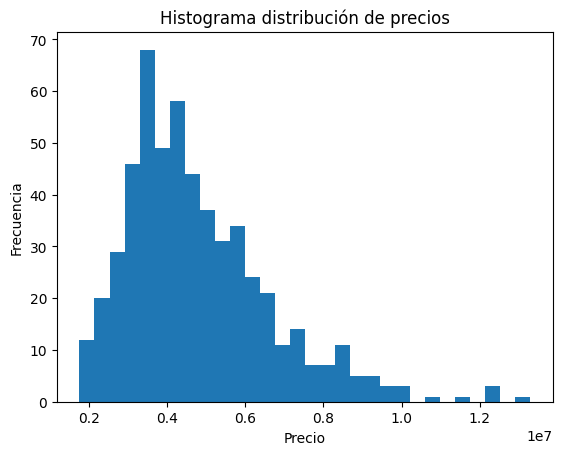

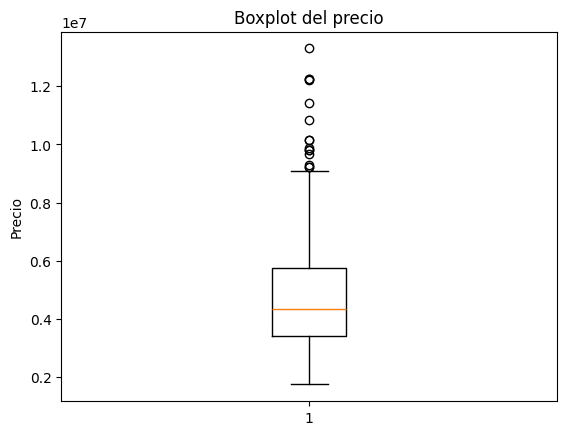

In [12]:
plt.figure()
plt.hist(df["price"].dropna(), bins = 30)
plt.title("Histograma distribución de precios")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()

#Boxplot
plt.figure()
plt.boxplot(df["price"].dropna(), vert = True)
plt.title("Boxplot del precio")
plt.ylabel("Precio")
plt.show()

1 Se revisa si distribución es simétrica o sesgada (colas) y 
2. Revision outliers en boxplot

Pairplot de numéricas

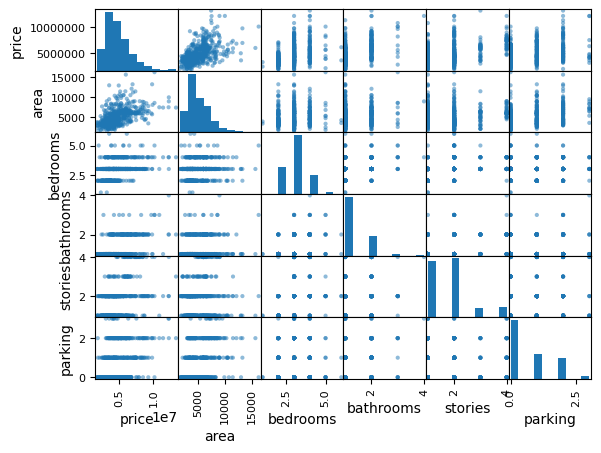

In [17]:
num_columnas = df.select_dtypes(include=[np.number]).columns.tolist()

#limitamos número de columnas para no saturar
max_cols = 6
plot_cols = num_columnas[:max_cols] if len(num_columnas) > max_cols else num_columnas

axes = scatter_matrix(df[plot_cols].dropna())


**Mapa de calor con correlaciones**

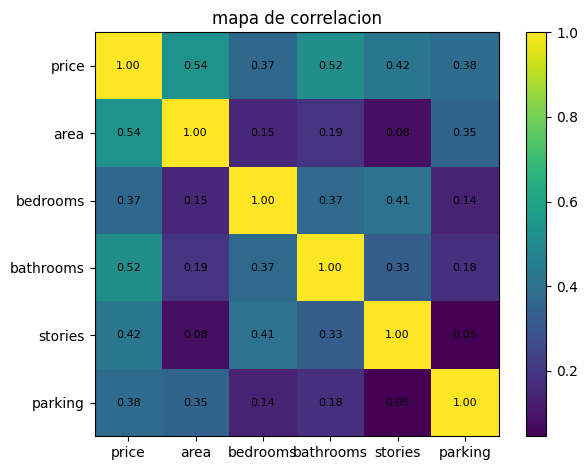


Correlaciones con price (desc):
area         0.535997
bathrooms    0.517545
stories      0.420712
parking      0.384394
bedrooms     0.366494
Name: price, dtype: float64


In [ ]:
corr = df.select_dtypes(include=[np.number]).corr()

plt.figure()
plt.imshow(corr, interpolation= "nearest")
plt.title("mapa de correlacion")
plt.xticks(range(len(corr.columns)),corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)

#anoto valores

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        plt.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center", fontsize=8)


plt.colorbar()
plt.tight_layout()
plt.show()

# Lista rápida: correlaciones con price (ordenadas)
if "price" in corr.columns:
    print("\nCorrelaciones con price (desc):")
    print(corr["price"].drop("price").sort_values(ascending=False))

**Preprocesamiento**

Imputación de nulos

In [ ]:
orig_num_cols = df.select_dtypes(include=[np.number]).columns.drop("price").tolist()
orig_cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()


#Calculo la mediana con la que rellenaré valores nans
for c in orig_num_cols: 
    med = df[c].median() 
    df[c] = df[c].fillna(med)

#Categóricas las relleno con la moda
for c in orig_cat_cols:
    mode_val = df[c].mode(dropna=True)
    df[c] = df[c].fillna(mode_val)

    

['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
['area', 'bedrooms', 'bathrooms', 'stories', 'parking']


One-hot encoding

In [ ]:
df_enc = pd.get_dummies(df, columns=orig_cat_cols, drop_first=True)

y = df_enc["price"].values
x = df_enc.drop(columns=["price"]).copy()

print("Shape X, y:", x.shape, len(y))
print("Primeras columnas de X:", x.columns[:10].tolist())


Shape X, y: (545, 13) 545
Primeras columnas de X: ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'mainroad_yes', 'guestroom_yes', 'basement_yes', 'hotwaterheating_yes', 'airconditioning_yes']


**Train / Test split + Estandaricacion var numéricas**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    x,y,test_size = 0.2,
)

#Escala columnas numéricas para acelerar convergencia
scaler = StandardScaler()

num_cols_in_X = [c for c in orig_num_cols if c in x.columns]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols_in_X] = scaler.fit_transform(X_train[num_cols_in_X])
X_test_scaled[num_cols_in_X] = scaler.transform(X_test[num_cols_in_X])

print("Columnas escaladas:", num_cols_in_X)
print("X_train_scaled shape:", X_train_scaled.shape)





Columnas escaladas: ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
X_train_scaled shape: (436, 13)


**Modelo: Regresión Lineal + Coeficientes**

In [ ]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_scaled,y_train)

print("Intercepto b0: ", linreg.intercept_)

coefs = pd.Series(linreg.coef_, index= X_train_scaled.columns).sort_values()

print("\nTop 10 coeficientes por magnitud (|beta|):")
display(coefs.head(10))

# Comentario corto sobre interpretación:
print("\nNota: Como estandarizamos numéricas, un coeficiente positivo indica que al aumentar 1 desviación estándar")
print("en esa variable (o pasar de 0 a 1 en un dummy), el precio esperado sube en 'beta' unidades de price,")
print("manteniendo el resto constante.")

Intercepto b0:  4049484.5841230946

Top 10 coeficientes por magnitud (|beta|):


furnishingstatus_unfurnished      -397237.298800
furnishingstatus_semi-furnished      4563.410977
bedrooms                            70035.148941
parking                            260745.387537
mainroad_yes                       307659.924015
basement_yes                       322959.307656
stories                            375660.821982
guestroom_yes                      430661.876533
bathrooms                          547758.321270
area                               569266.712433
dtype: float64


Nota: Como estandarizamos numéricas, un coeficiente positivo indica que al aumentar 1 desviación estándar
en esa variable (o pasar de 0 a 1 en un dummy), el precio esperado sube en 'beta' unidades de price,
manteniendo el resto constante.


**Metricas**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = linreg.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"MSE : {mse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R^2 : {r2:.4f}")


MSE : 902605484289.14
MAE : 722638.55
R^2 : 0.6209


**Graficos predicción vs valor real**

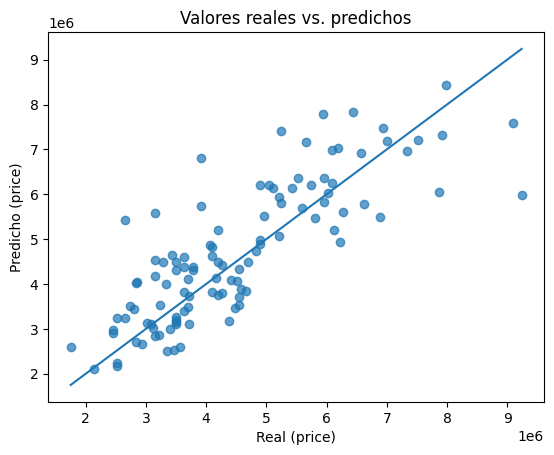

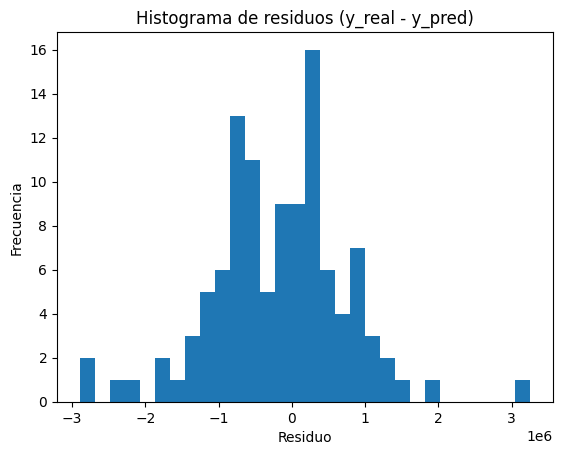

In [ ]:
import numpy as np

plt.figure()
plt.scatter(y_test,y_pred,alpha=0.7)
min_v = min(y_test.min(), y_pred.min())
max_v = max(y_test.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v])  # línea y=x
plt.title("Valores reales vs. predichos")
plt.xlabel("Real (price)")
plt.ylabel("Predicho (price)")
plt.show()

# 2) Histograma de residuos
residuals = y_test - y_pred
plt.figure()
plt.hist(residuals, bins=30)
plt.title("Histograma de residuos (y_real - y_pred)")
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.show()